In [1]:
import os
import random

#data
import pandas as pd

# chemistry
import rdkit
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import Lipinski

# math
import numpy as np

# plotting
from matplotlib import pyplot as plt

# Machine learning
import sklearn
from sklearn import tree

Here I am training a Decision Tree model to classify if two pairs of ligands are suitable for template based docking:

1) The continuous rmsd values are divided into 2 classes: bellow 2.5 A and above 2.5 A

2) No values are considered inconclusive

3) Test set and training set don't have the same molecules

In [2]:
# get the data set
df = pd.read_csv('../../../Analysis_of_Docking/data/rmsd_values_featurized_without_bad_pairs.csv') #../data/rmsd_values_featurized.csv')

In [3]:
# Assign binary labels to the dataset
df['binned_rmsd'] = None

for index, rmsd in df[['rmsd']].itertuples():
    if rmsd < 2.5:
        df.at[index, 'binned_rmsd'] = 1
    else:
        df.at[index, 'binned_rmsd'] = 0

df = df[df['template']!=df['docked']]

# Features that will be used to classify:
not_features = ['template', 'docked', 'rmsd', 'uniprot_id', 'mcs_smartsString',
                'smiles_template', 'smiles_docked', 'binned_rmsd']
features = df.drop(columns=not_features).columns.tolist()
print(features)

['template_HeavyAtomCount', 'template_NHOHCount', 'template_NOCount', 'template_RingCount', 'template_NumHAcceptors', 'template_NumHDonors', 'template_NumHeteroAtoms', 'template_NumRotatableBonds', 'docked_HeavyAtomCount', 'docked_NHOHCount', 'docked_NOCount', 'docked_RingCount', 'docked_NumHAcceptors', 'docked_NumHDonors', 'docked_NumHeteroAtoms', 'docked_NumRotatableBonds', 'mcs_HeavyAtomCount', 'mcs_NOCount', 'mcs_RingCount', 'mcs_NumHeteroAtoms', 'mcs_template_NHOHCount', 'mcs_docked_NHOHCount', 'mcs_template_NumHAcceptors', 'mcs_docked_NumHAcceptors', 'mcs_template_NumHDonors', 'mcs_docked_NumHDonors', 'mcs_template_NumRotatableBonds', 'mcs_docked_NumRotatableBonds', 'ec_tanimoto_similarity', 'fc_tanimoto_similarity']


In [4]:
no_inconcl_df = df.reset_index(drop=True)

In [5]:
# create a list of all the sets that exist of template_molecule, docked_molecule
list_of_sets = []
list_of_indexes = []
for index, template, docked in no_inconcl_df[['template', 'docked']].itertuples():
    if {template, docked} not in list_of_sets:
        list_of_sets += [{template, docked}]
        list_of_indexes += [[index]]
    else:
        list_of_indexes[list_of_sets.index({template, docked})] += [index]

list_of_sets_copy = list_of_sets.copy()
list_of_lists = [[]]
list_of_lists_indexes = [[]]
while_loop_controller_1 = True
while while_loop_controller_1:
    set1 = list_of_sets_copy[0]
    tempset = set()
    tempset.update(set1)
    while_loop_controller_2 = True
    while while_loop_controller_2:
        i = 0
        i_s = []
        for set2 in list_of_sets_copy:
            if not tempset.isdisjoint(set2):
                tempset.update(set2)
                list_of_lists[-1] += [set2]
                list_of_lists_indexes[-1] += list_of_indexes[list_of_sets.index(set2)]
                i_s += [i]
            i += 1
        if len(i_s) == 0:
            while_loop_controller_2 = False
        list_of_sets_copy = [list_of_sets_copy[j] for j in range(len(list_of_sets_copy)) if j not in i_s]
    if len(list_of_sets_copy) > 0:
        list_of_lists += [[]]
        list_of_lists_indexes += [[]]
    else:
        while_loop_controller_1 = False

In [6]:
size_of_groups = {}
no_inconcl_df['group'] = -1
group = 0
for list in list_of_lists_indexes:
    group += 1
    size_of_groups[group] = len(list)
    for index in list:
        no_inconcl_df.at[index, 'group'] = group

In [7]:
print(size_of_groups)

{1: 7399, 2: 4362, 3: 2421, 4: 6, 5: 788, 6: 1053, 7: 726, 8: 1251, 9: 408, 10: 695, 11: 593, 12: 260, 13: 106, 14: 2, 15: 94, 16: 39, 17: 5, 18: 119, 19: 504, 20: 2, 21: 483, 22: 313, 23: 248, 24: 222, 25: 324, 26: 314, 27: 39, 28: 199, 29: 218, 30: 93, 31: 2, 32: 13, 33: 190, 34: 162, 35: 20, 36: 2, 37: 3, 38: 55, 39: 92, 40: 76, 41: 89, 42: 84, 43: 103, 44: 116, 45: 48, 46: 118, 47: 74, 48: 11, 49: 17, 50: 37, 51: 53, 52: 6, 53: 45, 54: 23, 55: 2, 56: 37, 57: 48, 58: 22, 59: 7, 60: 7, 61: 11, 62: 20, 63: 8, 64: 7, 65: 11, 66: 2, 67: 5, 68: 6, 69: 8, 70: 2, 71: 2, 72: 2, 73: 2, 74: 4, 75: 4, 76: 1, 77: 6}


In [10]:
def check_sizes_of_folds(folds):
    sizes = []
    for fold in folds:
        sizes += [sum([size_of_groups[g] for g in fold])]
    return sizes

k = 5

groups = no_inconcl_df['group'].drop_duplicates().values


base_size = len(groups)//(k)
base_rest = len(groups)%(k)

print(base_size, base_rest)

random.shuffle(groups)
folds = [groups[i*base_size:(i+1)*base_size] for i in range(k)]

for i in range(base_rest):
    folds[-(i+1)] = np.append(groups[-(i+1)], folds[-(i+1)])

folds, check_sizes_of_folds(folds)

15 2


([array([ 6, 13, 34, 60, 44, 51, 29, 54, 15, 55, 66, 73,  8, 77, 40]),
  array([38, 18, 57, 72, 58, 74,  3, 28, 23, 50, 20,  5, 67, 35, 21]),
  array([ 2, 64, 22, 26, 11, 25, 68, 37, 32,  7, 41, 76, 43, 19, 47]),
  array([24,  4, 42, 36, 63, 52, 10,  9, 33, 69, 48, 14, 75, 65, 30, 70]),
  array([27, 12, 45, 61, 56, 31, 17, 16, 49, 53, 46, 71, 39, 62,  1, 59])],
 [3171, 4453, 7432, 1752, 8141])

In [11]:
folds_dfs = [[]]
for fold in folds:
    for group in fold:
        folds_dfs[-1] += [no_inconcl_df.loc[no_inconcl_df['group']==group]]
    folds_dfs[-1] = pd.concat(folds_dfs[-1])
    folds_dfs += [[]]

In [12]:
validation_fold_df = folds_dfs[0]
train_test_folds_dfs = []
for i in range(1,k):
    train_test_folds_dfs += [[]]
    train_test_folds_dfs[-1] += [pd.concat([folds_dfs[j] for j in range(1,k) if j!=i])]
    train_test_folds_dfs[-1] += [folds_dfs[i]]

In [ ]:
'''
# Oversample the underrepresented
for i in range(k-1):
    # the training
    len_0_values = len(train_test_folds_dfs[i][0].loc[train_test_folds_dfs[i][0]['binned_rmsd']==0])
    len_1_values = len(train_test_folds_dfs[i][0].loc[train_test_folds_dfs[i][0]['binned_rmsd']==1])
    print(len_0_values, len_1_values)
    train_test_folds_dfs[i][0] = pd.concat([train_test_folds_dfs[i][0].loc[train_test_folds_dfs[i][0]['binned_rmsd']==0]] +
                                            [train_test_folds_dfs[i][0].loc[train_test_folds_dfs[i][0]['binned_rmsd']==1]] * (len_0_values//len_1_values) +
                                            [train_test_folds_dfs[i][0].loc[train_test_folds_dfs[i][0]['binned_rmsd']==1].head(len_0_values%len_1_values)])
    len_0_values = len(train_test_folds_dfs[i][0].loc[train_test_folds_dfs[i][0]['binned_rmsd']==0])
    len_1_values = len(train_test_folds_dfs[i][0].loc[train_test_folds_dfs[i][0]['binned_rmsd']==1])
    print('train')
    print(len_0_values, len_1_values)
    # the test
    len_0_values = len(train_test_folds_dfs[i][1].loc[train_test_folds_dfs[i][1]['binned_rmsd']==0])
    len_1_values = len(train_test_folds_dfs[i][1].loc[train_test_folds_dfs[i][1]['binned_rmsd']==1])
    print(len_0_values, len_1_values)
    train_test_folds_dfs[i][1] = pd.concat([train_test_folds_dfs[i][1].loc[train_test_folds_dfs[i][1]['binned_rmsd']==0]] +
                                            [train_test_folds_dfs[i][1].loc[train_test_folds_dfs[i][1]['binned_rmsd']==1]] * (len_0_values//len_1_values) +
                                            [train_test_folds_dfs[i][1].loc[train_test_folds_dfs[i][1]['binned_rmsd']==1].head(len_0_values%len_1_values)])
    len_0_values = len(train_test_folds_dfs[i][1].loc[train_test_folds_dfs[i][1]['binned_rmsd']==0])
    len_1_values = len(train_test_folds_dfs[i][1].loc[train_test_folds_dfs[i][1]['binned_rmsd']==1])
    print('test')
    print(len_0_values, len_1_values)
    print('')
'''

In [13]:
train_test_folds_indexes = []
for train, test in train_test_folds_dfs:
    train_test_folds_indexes += [[train.index.values, test.index.values]]

In [14]:
# choose with which max_depth I should start
depth_of_tree = []
# instantiate the classifier:
clf = tree.DecisionTreeClassifier(class_weight="balanced")
for train, test in train_test_folds_dfs:
    X_train = train.drop(columns=not_features+['group']).values.tolist()
    Y_train = train['binned_rmsd'].values.tolist()
    clf = clf.fit(X_train, Y_train)
    depth_of_tree += [clf.get_depth()]

np.average(depth_of_tree), np.median(depth_of_tree)

(33.25, 34.0)

In [15]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(estimator=tree.DecisionTreeClassifier(class_weight="balanced"),
                 param_grid={'max_depth':[i for i in range(1,15)]},
                 scoring={'f1_score':sklearn.metrics.make_scorer(sklearn.metrics.f1_score),
                          'recall':sklearn.metrics.make_scorer(sklearn.metrics.recall_score),
                          'precision':sklearn.metrics.make_scorer(sklearn.metrics.precision_score)},
                 refit='f1_score',
                 n_jobs=-1,
                 cv=train_test_folds_indexes,
                 verbose=1)

In [16]:
feats = no_inconcl_df.drop(columns=not_features + ['group']).values.tolist()
labels = no_inconcl_df[['binned_rmsd']].values.tolist()

In [17]:
clf.fit(feats, labels)

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  1.0min finished


GridSearchCV(cv=[[array([ 7399,  7400,  7401, ..., 24838, 24839, 24840]),
                  array([23678, 23679, 23680, ..., 21313, 21314, 21315])],
                 [array([23678, 23679, 23680, ..., 24838, 24839, 24840]),
                  array([ 7399,  7400,  7401, ..., 24530, 24531, 24532])],
                 [array([23678, 23679, 23680, ..., 24838, 24839, 24840]),
                  array([21877, 21878, 21879, ..., 23286, 24926, 24927])],
                 [array([23678, 23679, 23680, ..., 23286, 24926, 24927]),
                  array([22737, 22738, 22739, ..., 24838, 24839, 24840])]],
             estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14]},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'reca

In [18]:
cv_results = clf.cv_results_
cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_f1_score', 'split1_test_f1_score', 'split2_test_f1_score', 'split3_test_f1_score', 'mean_test_f1_score', 'std_test_f1_score', 'rank_test_f1_score', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision'])

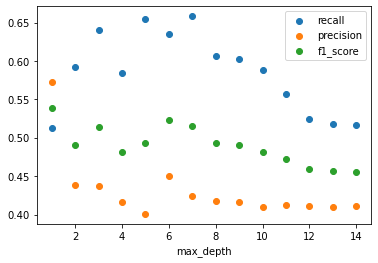

In [19]:
plt.scatter(cv_results['param_max_depth'], cv_results['mean_test_recall'], label='recall')
plt.scatter(cv_results['param_max_depth'], cv_results['mean_test_precision'], label='precision')
plt.scatter(cv_results['param_max_depth'], cv_results['mean_test_f1_score'], label='f1_score')
plt.xlabel('max_depth')
plt.legend()
plt.show()

In [20]:
validation_X = validation_fold_df.drop(columns=not_features + ['group']).values.tolist()
validation_Y = validation_fold_df['binned_rmsd'].values.tolist()

In [21]:
final_train_df = no_inconcl_df.loc[train_test_folds_indexes[0][0].tolist() +
                                   train_test_folds_indexes[0][1].tolist()]
final_train_X = final_train_df.drop(columns=not_features + ['group']).values.tolist()
final_train_Y = final_train_df['binned_rmsd'].values.tolist()

In [22]:
clf = tree.DecisionTreeClassifier(max_depth=6, class_weight="balanced")
clf.fit(final_train_X, final_train_Y)

print(sklearn.metrics.classification_report(validation_Y, clf.predict(validation_X)))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1539
           1       0.75      0.76      0.75      1632

    accuracy                           0.74      3171
   macro avg       0.74      0.74      0.74      3171
weighted avg       0.74      0.74      0.74      3171



In [35]:
# Warning: impurity-based feature importances can be misleading for high cardinality features
# (many unique values). See sklearn.inspection.permutation_importance as an alternative.
importance = clf.feature_importances_.tolist()
feat_imp = [ele for ele in zip(features, importance)]
feat_imp.sort(key=lambda x:x[1], reverse=True)
#feat_imp

In [31]:
from sklearn import inspection

r = inspection.permutation_importance(clf, validation_X, validation_Y,
                                  scoring=sklearn.metrics.make_scorer(sklearn.metrics.f1_score),
                                  n_repeats=100,
                                  n_jobs=-1)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<30}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

docked_HeavyAtomCount         0.083 +/- 0.010
mcs_RingCount                 0.075 +/- 0.008
ec_tanimoto_similarity        0.058 +/- 0.008
fc_tanimoto_similarity        0.041 +/- 0.008
mcs_docked_NumHDonors         0.025 +/- 0.006
mcs_NOCount                   0.015 +/- 0.006
docked_NOCount                0.012 +/- 0.003


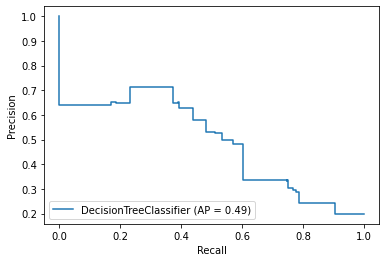

In [21]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(clf, validation_X, validation_Y)

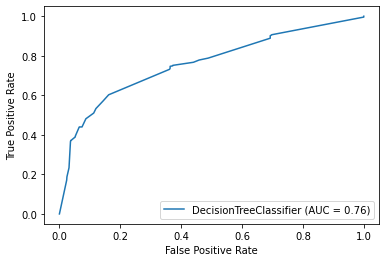

In [22]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, validation_X, validation_Y)

In [23]:
validation_fold_df['dt_score'] = clf.predict_proba(validation_X)[:,1]

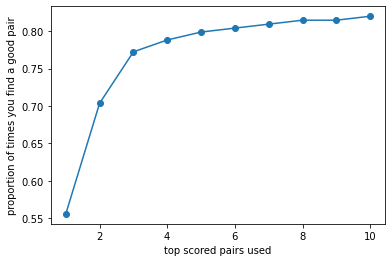

In [24]:
range = [1,2,3,4,5,6,7,8,9,10]
proportion = []
for i in range:
    count = 0
    for docked in validation_fold_df['docked'].drop_duplicates().values:
            if validation_fold_df.loc[(validation_fold_df['docked']==docked)] \
                                 .sort_values(by=['dt_score'], ascending=False)[:i] \
                                 .loc[validation_fold_df['rmsd']<2].shape[0] > 0:

                count += 1

    proportion += [count/validation_fold_df['docked'].drop_duplicates().shape[0]]

plt.scatter(range, proportion)
plt.plot(range, proportion)
plt.xlabel('top scored pairs used')
plt.ylabel('proportion of times you find a good pair')
plt.show()

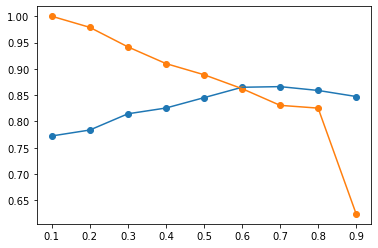

In [27]:
top = 3
range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
proportion = []
valids = []
for i in range:
    count = 0
    valid = 0
    for docked in validation_fold_df['docked'].drop_duplicates().values:
        if validation_fold_df.loc[(validation_fold_df['docked']==docked)
                                  & (validation_fold_df['dt_score']>i)].shape[0] > 0:
            valid += 1
            if validation_fold_df.loc[(validation_fold_df['docked']==docked) & (validation_fold_df['dt_score']>i)] \
                                 .sort_values(by=['dt_score'], ascending=False)[:top] \
                                 .loc[validation_fold_df['rmsd']<2].shape[0] > 0:
                count += 1
    valids += [valid/validation_fold_df['docked'].drop_duplicates().shape[0]]
    proportion += [count/valid]

plt.scatter(range, proportion)
plt.plot(range, proportion)
plt.scatter(range, valids)
plt.plot(range, valids)
plt.show()


In [ ]:
validation_fold_df['dt_score'] = clf.predict_proba(validation_X)[:,1]
best_pairs_df = []
for docked in validation_fold_df['docked'].drop_duplicates().values:
    best_pairs_df += [validation_fold_df.loc[validation_fold_df['docked']==docked].sort_values(by=['dt_score'], ascending=False)[
                          ['rmsd', 'dt_score']].reset_index(drop=True).loc[[0]]]

best_pairs_df = pd.concat(best_pairs_df)
